In [1]:
import numpy as np
import xarray as xr
import os
import glob
from pathlib import Path 
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import time
import requests
import s3fs
from os.path import dirname, join
import datetime
import myDate
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [10]:
alongtrack_file_dir = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_nosicapplied/')
alongtrack_file_dir_randomnoise = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/')
alongtrack_file_dir_missingdata = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_missingdata_nosicapplied/')
alongtrack_file_dir_orbiterror_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/')
alongtrack_file_dir_3errors_2cm = Path('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/')

beckley_dailyfile_dir = Path('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/')

main_dir = Path('/home/jpluser/ECCO_GMSL/')
output_dir = Path('/home/jpluser/ECCO_GMSL/Data/GMSL/')

fig_dir = Path('/home/jpluser/ECCO_GMSL/Figures/')

# Compute Beckley's daily files along track GMSL (Beckley's style)

In [3]:
beckley_alongtrack_dailyfile_dir = list(beckley_dailyfile_dir.glob('MERGED*h5'))
beckley_alongtrack_dailyfile_dir=np.sort(beckley_alongtrack_dailyfile_dir)
beckley_alongtrack_dailyfile_dir

array([PosixPath('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh19920925.h5'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh19920926.h5'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh19920927.h5'),
       ...,
       PosixPath('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh20171229.h5'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh20171230.h5'),
       PosixPath('/home/jpluser/ECCO_GMSL/Data/Beckley_dailyfiles/MERGED_ALT-alt_ssh20171231.h5')],
      dtype=object)

In [5]:
beckley_gmsl_tmp=[]
time_gmsl=[]

start_date = np.datetime64('1950-01-01')
time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)
i=0
lat=[]
lon=[]
ssh=[]
ssh_smoothed=[]
time=[]
for j in range(0,10):
    [year,month,day]=myDate.jj2date(time_fiction[i+j])
    try:
        ECCO_alongtrack_file_cycle=list(beckley_dailyfile_dir.glob('MERGED_ALT-alt_ssh'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*h5'))[0]
        print('MERGED_ALT-alt_ssh'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*h5')
        ncf = netCDF4.Dataset(ECCO_alongtrack_file_cycle, diskless=True, persist=False)
        nch = ncf.groups.get('data')
        xds = xr.open_dataset(xr.backends.NetCDF4DataStore(nch))
        lat=np.hstack((lat,xds.lats))
        lon=np.hstack((lon,xds.lons))
        ssh=np.hstack((ssh,xds.ssh))
        ssh_smoothed=np.hstack((ssh_smoothed,xds.ssh_smoothed))
        time=np.hstack((time,xds.time))
    except:
        print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))
    alongtrack = {
        'ssh': xr.DataArray(ssh, dims='time', coords={'time': time}),
        'lat': xr.DataArray(lat, dims='time', coords={'time': time}),
        'lon': xr.DataArray(lon, dims='time', coords={'time': time})
    }
    alongtrack = xr.Dataset(alongtrack)
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))

no file on: 19920923
no file on: 19920924
MERGED_ALT-alt_ssh19920925*h5
MERGED_ALT-alt_ssh19920926*h5
MERGED_ALT-alt_ssh19920927*h5
MERGED_ALT-alt_ssh19920928*h5
MERGED_ALT-alt_ssh19920929*h5
MERGED_ALT-alt_ssh19920930*h5
MERGED_ALT-alt_ssh19921001*h5
MERGED_ALT-alt_ssh19921002*h5


In [6]:
alongtrack

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 266441)
Coordinates:
  * time     (time) float64 2MB 2.44e+08 2.44e+08 ... 2.447e+08 2.447e+08
Data variables:
    ssh      (time) float64 2MB 0.05143 0.04708 0.08729 ... 0.09702 0.0842
    lat      (time) float64 2MB 64.21 64.19 64.17 64.15 ... -60.66 -60.69 -60.72
    lon      (time) float64 2MB 188.8 188.9 189.0 189.1 ... 65.3 65.39 65.47

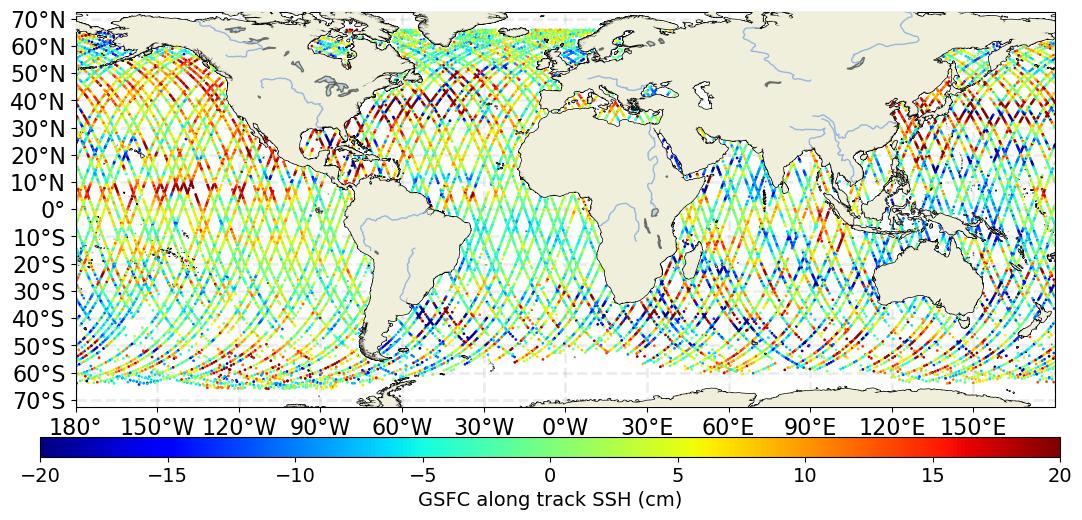

In [11]:
lonmin = -180
lonmax = 180
latmin = -90
latmax = 90
box = [lonmin, lonmax, latmin, latmax]
latstep = 10
lonstep=30
land=True

import cartopy

def init_cartopy_global(projection, box, latstep, lonstep, land, zorder=4,**karg):
    import matplotlib.pyplot as plt
    import numpy
    import cartopy
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.feature as cfeature

    # ax = plt.axes(projection=projection)
    ax=plt.subplot(1,1,1,projection=projection)
    if land==True:
        land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor=cfeature.COLORS['land'])
        ax.add_feature(land_10m, zorder=zorder)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=zorder,edgecolor='black')
    ax.add_feature(cartopy.feature.RIVERS, zorder=zorder)
    ax.coastlines('10m')
    # ax.stock_img()
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1]),lonstep), crs=projection)
    ax.set_yticks(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3]),latstep), crs=projection)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(axis='both', which='major', labelsize=16)
    gl = ax.gridlines(draw_labels=False, linestyle='--', linewidth=2, alpha=0.15, color='gray')
    if 'pacific' in karg:
        gl.xlocator = mticker.FixedLocator(numpy.arange(box[1],box[0]+360,lonstep))
    else:
        gl.xlocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[0]),numpy.floor(box[1])+lonstep,lonstep))
    gl.ylocator = mticker.FixedLocator(numpy.arange(numpy.floor(box[2]),numpy.floor(box[3])+latstep,latstep))
    return ax, gl


kk=12

fig = plt.figure(figsize=(15,5))
data_proj = cartopy.crs.PlateCarree(central_longitude=0)
map_proj = cartopy.crs.PlateCarree(central_longitude=0)
ax, gl = init_cartopy_global(map_proj, box, latstep, lonstep, land) 
palette=plt.cm.jet
palette.set_bad('w',1.0)
pp = plt.scatter(alongtrack.lon[::kk],alongtrack.lat[::kk],c=alongtrack.ssh[::kk]*100, s=1,cmap=palette,vmin=-20,vmax=20,transform=data_proj) 
plt.subplots_adjust(right=0.9,left=0.1,top=0.99,bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.68, 0.04])
h=plt.colorbar(pp, cax=cbar_ax,orientation='horizontal')
h.set_label('GSFC along track SSH (cm)',fontsize=14)
h.ax.tick_params(labelsize=14)
plt.savefig(fig_dir / 'map_cycle1_beckley.png',dpi=200,transparent=False,facecolor='white')

In [7]:
beckley_gmsl_tmp=[]
time_gmsl=[]

start_date = np.datetime64('1950-01-01')
time_fiction=range(myDate.date2jj(1992,9,23),myDate.date2jj(2017,12,31)+11)
for i in np.arange(0,len(time_fiction)-10,10):
    lat=[]
    lon=[]
    ssh=[]
    ssh_smoothed=[]
    time=[]
    for j in range(0,10):
        [year,month,day]=myDate.jj2date(time_fiction[i+j])
        try:
            ECCO_alongtrack_file_cycle=list(beckley_dailyfile_dir.glob('MERGED_ALT-alt_ssh'+str(year)+str(month).zfill(2)+str(day).zfill(2)+'*h5'))[0]
            ncf = netCDF4.Dataset(ECCO_alongtrack_file_cycle, diskless=True, persist=False)
            nch = ncf.groups.get('data')
            xds = xr.open_dataset(xr.backends.NetCDF4DataStore(nch))
            lat=np.hstack((lat,xds.lats))
            lon=np.hstack((lon,xds.lons))
            ssh=np.hstack((ssh,xds.ssh))
            ssh_smoothed=np.hstack((ssh_smoothed,xds.ssh_smoothed))
            time=np.hstack((time,xds.time))
        except:
            print('no file on: '+str(year)+str(month).zfill(2)+str(day).zfill(2))
    try:
        alongtrack = {
            'ssh': xr.DataArray(ssh, dims='time', coords={'time': time}),
            'lat': xr.DataArray(lat, dims='time', coords={'time': time}),
            'lon': xr.DataArray(lon, dims='time', coords={'time': time})
        }
        alongtrack = xr.Dataset(alongtrack)
        alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
        SSH_at_xy_ano=alongtrack.ssh
        w=np.cos(np.deg2rad(alongtrack.lat))
        w=w.where(np.isfinite(SSH_at_xy_ano))
        time_gmsl = np.hstack((time_gmsl,time_fiction[i]))
        beckley_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
    except:
        time_gmsl = np.hstack((time_gmsl,time_fiction[i]))
        beckley_gmsl_tmp.append(np.nan)

beckley_gmsl = xr.concat(beckley_gmsl_tmp, dim='time')
beckley_gmsl

no file on: 19920923
no file on: 19920924
no file on: 19930723
no file on: 19930724
no file on: 19930725
no file on: 19940317
no file on: 19951127
no file on: 19951128
no file on: 19951129
no file on: 19951130
no file on: 19951201
no file on: 19951202
no file on: 19951203
no file on: 19951204
no file on: 19951205
no file on: 19951206
no file on: 19960121
no file on: 19960122
no file on: 19970605
no file on: 19970606
no file on: 19990210
no file on: 19990831
no file on: 19990901
no file on: 19990902
no file on: 19990903
no file on: 20000403
no file on: 20000404
no file on: 20000405
no file on: 20031120
no file on: 20031121
no file on: 20031122
no file on: 20031123
no file on: 20031124
no file on: 20031125
no file on: 20031126
no file on: 20031127
no file on: 20040216
no file on: 20040217
no file on: 20040218
no file on: 20040219
no file on: 20040220
no file on: 20040404
no file on: 20050921
no file on: 20050922
no file on: 20050923
no file on: 20050924
no file on: 20050925
no file on: 2

<xarray.DataArray (time: 924)> Size: 7kB
array([ 1.57821231e-02,  1.11803818e-02,  4.24610970e-04, -5.41467601e-03,
       -6.37412259e-03, -9.48694433e-03, -4.00843194e-03, -1.38529941e-02,
       -1.67932575e-02, -1.76437758e-02, -1.77158452e-02, -2.03894238e-02,
       -2.35618304e-02, -2.09467686e-02, -1.77747807e-02, -1.80588782e-02,
       -1.69976960e-02, -1.77876019e-02, -1.95759654e-02, -1.88862169e-02,
       -1.99789099e-02, -1.92728377e-02, -2.12842404e-02, -2.15690325e-02,
       -2.36212436e-02, -2.20176616e-02, -1.91835920e-02, -1.86119084e-02,
       -1.76668094e-02, -1.73270209e-02, -1.43946363e-02, -1.84838022e-02,
       -1.51386916e-02, -1.19961527e-02, -1.20142168e-02, -1.35359747e-02,
       -1.25774002e-02, -1.00705848e-02, -6.33815058e-03, -9.86377661e-03,
       -1.27978377e-02, -1.38150132e-02, -1.45252527e-02, -1.54040542e-02,
       -1.15969388e-02, -1.01147544e-02, -1.17546333e-02, -1.39548240e-02,
       -1.00798546e-02, -1.10735354e-02, -1.74489111e-02, -1.84920034e-02,
       -1.67719222e-02, -1.51109216e-02, -1.31682016e-02, -1.39708261e-02,
       -1.50293820e-02, -1.56581295e-02, -1.86473905e-02, -1.97922545e-02,
       -1.98158185e-02, -1.79776127e-02, -1.85863425e-02, -1.82430019e-02,
       -2.27514878e-02, -1.64229781e-02, -1.58162887e-02, -1.41581793e-02,
       -1.33156904e-02, -1.18933174e-02, -1.06201869e-02, -7.75315635e-03,
       -8.30323224e-03, -9.43126088e-03, -6.46030034e-03, -5.75320115e-03,
       -6.28531494e-03, -2.39287801e-03, -8.25998846e-03, -1.16291822e-02,
...
        6.08903846e-02,  5.84718984e-02,  5.99786086e-02,  5.87591857e-02,
        5.64871731e-02,  5.51245144e-02,  5.25877227e-02,  5.87378223e-02,
        5.94855210e-02,  5.53260584e-02,  5.80546588e-02,  5.54193204e-02,
        5.52515104e-02,  5.26410030e-02,  5.60081726e-02,  5.05640638e-02,
        5.24349082e-02,  4.95450544e-02,  4.84292644e-02,  4.70816188e-02,
        4.67052208e-02,  4.99497661e-02,  5.09776267e-02,  5.12336629e-02,
        5.21567324e-02,  5.20326725e-02,  5.04175372e-02,  5.14797249e-02,
        5.11588475e-02,  5.26074300e-02,  5.85391065e-02,  6.03752938e-02,
        5.82429581e-02,  5.66912035e-02,  5.76555795e-02,  6.14351631e-02,
        5.90399000e-02,  6.10240545e-02,  6.30524617e-02,  6.17354285e-02,
        5.81247673e-02,  5.74680806e-02,  5.60469986e-02,  5.65075838e-02,
        5.51201273e-02,  5.39934651e-02,  5.12683301e-02,  5.30459315e-02,
        5.28222213e-02,  5.26678797e-02,  5.26951573e-02,  5.16044704e-02,
        5.03603853e-02,  4.96567532e-02,  4.79606617e-02,  4.68809534e-02,
        4.71312061e-02,  4.81414814e-02,  4.99367727e-02,  5.14737072e-02,
        5.08007194e-02,  5.08538260e-02,  5.16004921e-02,  5.60442176e-02,
        5.68788125e-02,  5.89636037e-02,  5.98069157e-02,  6.27347438e-02,
        6.38647438e-02,  6.12413689e-02,  6.19944990e-02,  6.26411626e-02,
        6.46399715e-02,  6.49585821e-02,  6.55171899e-02,  6.51491218e-02,
        6.36341240e-02,  6.38430432e-02,  6.15242731e-02,  6.00005072e-02])
Dimensions without coordinates: time

In [8]:
beckley_gmsl.name = 'gmsl_beckley_daily_alongtrack'
beckley_gmsl.attrs['units'] = 'm'
beckley_gmsl.attrs['summary'] = '10-day GMSL time series computed on the daily file alongtrack GSFC data'#, referenced to a 1996-2016 global mean SSH'
beckley_gmsl.time.attrs['long_name'] = 'mid day of the 10-day average'
beckley_gmsl['time']= start_date + np.timedelta64(1, 'D') * (time_gmsl+4) 
beckley_gmsl

<xarray.DataArray 'gmsl_beckley_daily_alongtrack' (time: 924)> Size: 7kB
array([ 1.57821231e-02,  1.11803818e-02,  4.24610970e-04, -5.41467601e-03,
       -6.37412259e-03, -9.48694433e-03, -4.00843194e-03, -1.38529941e-02,
       -1.67932575e-02, -1.76437758e-02, -1.77158452e-02, -2.03894238e-02,
       -2.35618304e-02, -2.09467686e-02, -1.77747807e-02, -1.80588782e-02,
       -1.69976960e-02, -1.77876019e-02, -1.95759654e-02, -1.88862169e-02,
       -1.99789099e-02, -1.92728377e-02, -2.12842404e-02, -2.15690325e-02,
       -2.36212436e-02, -2.20176616e-02, -1.91835920e-02, -1.86119084e-02,
       -1.76668094e-02, -1.73270209e-02, -1.43946363e-02, -1.84838022e-02,
       -1.51386916e-02, -1.19961527e-02, -1.20142168e-02, -1.35359747e-02,
       -1.25774002e-02, -1.00705848e-02, -6.33815058e-03, -9.86377661e-03,
       -1.27978377e-02, -1.38150132e-02, -1.45252527e-02, -1.54040542e-02,
       -1.15969388e-02, -1.01147544e-02, -1.17546333e-02, -1.39548240e-02,
       -1.00798546e-02, -1.10735354e-02, -1.74489111e-02, -1.84920034e-02,
       -1.67719222e-02, -1.51109216e-02, -1.31682016e-02, -1.39708261e-02,
       -1.50293820e-02, -1.56581295e-02, -1.86473905e-02, -1.97922545e-02,
       -1.98158185e-02, -1.79776127e-02, -1.85863425e-02, -1.82430019e-02,
       -2.27514878e-02, -1.64229781e-02, -1.58162887e-02, -1.41581793e-02,
       -1.33156904e-02, -1.18933174e-02, -1.06201869e-02, -7.75315635e-03,
       -8.30323224e-03, -9.43126088e-03, -6.46030034e-03, -5.75320115e-03,
       -6.28531494e-03, -2.39287801e-03, -8.25998846e-03, -1.16291822e-02,
...
        6.08903846e-02,  5.84718984e-02,  5.99786086e-02,  5.87591857e-02,
        5.64871731e-02,  5.51245144e-02,  5.25877227e-02,  5.87378223e-02,
        5.94855210e-02,  5.53260584e-02,  5.80546588e-02,  5.54193204e-02,
        5.52515104e-02,  5.26410030e-02,  5.60081726e-02,  5.05640638e-02,
        5.24349082e-02,  4.95450544e-02,  4.84292644e-02,  4.70816188e-02,
        4.67052208e-02,  4.99497661e-02,  5.09776267e-02,  5.12336629e-02,
        5.21567324e-02,  5.20326725e-02,  5.04175372e-02,  5.14797249e-02,
        5.11588475e-02,  5.26074300e-02,  5.85391065e-02,  6.03752938e-02,
        5.82429581e-02,  5.66912035e-02,  5.76555795e-02,  6.14351631e-02,
        5.90399000e-02,  6.10240545e-02,  6.30524617e-02,  6.17354285e-02,
        5.81247673e-02,  5.74680806e-02,  5.60469986e-02,  5.65075838e-02,
        5.51201273e-02,  5.39934651e-02,  5.12683301e-02,  5.30459315e-02,
        5.28222213e-02,  5.26678797e-02,  5.26951573e-02,  5.16044704e-02,
        5.03603853e-02,  4.96567532e-02,  4.79606617e-02,  4.68809534e-02,
        4.71312061e-02,  4.81414814e-02,  4.99367727e-02,  5.14737072e-02,
        5.08007194e-02,  5.08538260e-02,  5.16004921e-02,  5.60442176e-02,
        5.68788125e-02,  5.89636037e-02,  5.98069157e-02,  6.27347438e-02,
        6.38647438e-02,  6.12413689e-02,  6.19944990e-02,  6.26411626e-02,
        6.46399715e-02,  6.49585821e-02,  6.55171899e-02,  6.51491218e-02,
        6.36341240e-02,  6.38430432e-02,  6.15242731e-02,  6.00005072e-02])
Coordinates:
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the daily file alongtrack G...

In [9]:
fname = output_dir / ('GMSL_Beckley_dailyfiles_simpleweight.nc')
beckley_gmsl.to_netcdf(fname)

# Compute ECCO along track GMSL with simple weights

### No error
#### Compute the reference global mean SSH over 20 years 1996-2016

In [10]:
# ECCO_alongtrack_files=[]
# for year in range(1996,2017):
#     ECCO_alongtrack_files_tmp = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
#     ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
# print(np.sort(ECCO_alongtrack_files))

In [11]:
# alongtrack = xr.open_mfdataset(
#         paths=ECCO_alongtrack_files,
#         combine='nested',
#         concat_dim='i',
#         decode_cf=True,
#         compat='override',
#         coords='minimal',
#         chunks={'time': 1}  
#     )  
# alongtrack

In [12]:
# ref_mean=alongtrack.SSH_at_xy.mean(skipna=True).values
# print(ref_mean)

#### Compute GMSL 10-day time series

In [13]:
ECCO_alongtrack_files = list(alongtrack_file_dir.glob('*ECCO_V4r4_alongtrack_SSH*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
# print(ECCO_alongtrack_files)

In [14]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    w=np.cos(np.deg2rad(alongtrack.lat))
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
    
    # fig = plt.figure(figsize=(15,5))
    # cm = plt.get_cmap('gist_rainbow')
    # ax=fig.gca()
    # ax = plt.axes(projection=ccrs.Robinson( \
    #               central_longitude=-67, globe=None))
    # ax.gridlines()
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.COASTLINE)
    # kk=12
    # p=ax.scatter(alongtrack.lon[::kk],\
    #                      alongtrack.lat[::kk], \
    #                      c=(SSH_at_xy_ano*w)[::kk], s=1,\
    #                      transform=ccrs.PlateCarree(),
    #                      vmin=-1,vmax=1, cmap='jet')
alongtrack_gmsl = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [15]:
SSH_at_xy_ano

<xarray.DataArray 'SSH_at_xy' (i: 59523)> Size: 238kB
dask.array<where, shape=(59523,), dtype=float32, chunksize=(59523,), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] 8B 2017-12-31
    cycle_day   int64 8B 0
    cycle       int64 8B 924
    delta_days  int64 8B 9230
    lon         (i) float32 238kB dask.array<chunksize=(59523,), meta=np.ndarray>
    lat         (i) float32 238kB dask.array<chunksize=(59523,), meta=np.ndarray>
Dimensions without coordinates: i
Attributes:
    source:   ECCO V4r4

In [16]:
alongtrack_gmsl=alongtrack_gmsl.drop('cycle_day')
alongtrack_gmsl=alongtrack_gmsl.drop('delta_days')
alongtrack_gmsl.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl.attrs['units'] = 'm'
alongtrack_gmsl.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl.time.attrs['long_name'] = 'mid day of the 10-day average'
alongtrack_gmsl['time']=alongtrack_gmsl.time+(4*24*60*60*10**(9))
alongtrack_gmsl

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 4kB
dask.array<concatenate, shape=(924,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data

In [17]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_noerror_simpleweight_nomean_nosicapplied.nc')
alongtrack_gmsl.to_netcdf(fname)

### Random noise error
#### Compute the reference global mean SSH over 20 years 1996-2016

In [18]:
# ECCO_alongtrack_files=[]
# for year in range(1996,2017):
#     ECCO_alongtrack_files_tmp = list(alongtrack_file_dir_randomnoise.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
#     ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
# print(np.sort(ECCO_alongtrack_files))

In [19]:
# alongtrack = xr.open_mfdataset(
#         paths=ECCO_alongtrack_files,
#         combine='nested',
#         concat_dim='i',
#         decode_cf=True,
#         compat='override',
#         coords='minimal',
#         chunks={'time': 1}  
#     )  
# alongtrack

In [20]:
# ref_mean_randomnoise=alongtrack.SSH_at_xy.mean(skipna=True).values
# print(ref_mean_randomnoise)

#### Compute GMSL 10-day time series

In [21]:
ECCO_alongtrack_files = list(alongtrack_file_dir_randomnoise.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_randomnoise.nc')
 ...
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30_randomnoise.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_randomnoise_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31_randomnoise.nc')]


In [22]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    w=np.cos(np.deg2rad(alongtrack.lat))
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_randomnoise = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [23]:
alongtrack_gmsl_randomnoise=alongtrack_gmsl_randomnoise.drop('cycle_day')
alongtrack_gmsl_randomnoise=alongtrack_gmsl_randomnoise.drop('delta_days')
alongtrack_gmsl_randomnoise.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_randomnoise.attrs['units'] = 'm'
alongtrack_gmsl_randomnoise.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with random noise'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_randomnoise.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_randomnoise['time']=alongtrack_gmsl_randomnoise.time+(4*24*60*60*10**(9))
alongtrack_gmsl_randomnoise

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 7kB
dask.array<concatenate, shape=(924,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [24]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_randomnoise_simpleweight_nomean_nosicapplied.nc')
alongtrack_gmsl_randomnoise.to_netcdf(fname)

### Missing data
#### Compute the reference global mean SSH over 20 years 1996-2016

In [25]:
# ECCO_alongtrack_files=[]
# for year in range(1996,2017):
#     ECCO_alongtrack_files_tmp = list(alongtrack_file_dir_missingdata.glob('*ECCO_V4r4_alongtrack_SSH_*'+str(year)+'*nc'))
#     ECCO_alongtrack_files.extend(ECCO_alongtrack_files_tmp)
# print(np.sort(ECCO_alongtrack_files))

In [26]:
# alongtrack = xr.open_mfdataset(
#         paths=ECCO_alongtrack_files,
#         combine='nested',
#         concat_dim='i',
#         decode_cf=True,
#         compat='override',
#         coords='minimal',
#         chunks={'time': 1}  
#     )  
# alongtrack

In [27]:
# ref_mean_missingdata=alongtrack.SSH_at_xy.mean(skipna=True).values
# print(ref_mean_missingdata)

#### Compute GMSL 10-day time series

In [28]:
ECCO_alongtrack_files = list(alongtrack_file_dir_missingdata.glob('*ECCO_V4r4_alongtrack_SSH*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
# print(ECCO_alongtrack_files)

In [29]:
alongtrack_gmsl_tmp_missingdata=[]
ind_vec=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano_missingdata=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    w=np.cos(np.deg2rad(alongtrack.lat))
    w=w.where(np.isfinite(SSH_at_xy_ano_missingdata))
    alongtrack_gmsl_tmp_missingdata.append((SSH_at_xy_ano_missingdata*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_missingdata = xr.concat(alongtrack_gmsl_tmp_missingdata, dim='time')

In [30]:
alongtrack_gmsl_missingdata=alongtrack_gmsl_missingdata.drop('cycle_day')
alongtrack_gmsl_missingdata=alongtrack_gmsl_missingdata.drop('delta_days')
alongtrack_gmsl_missingdata.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_missingdata.attrs['units'] = 'm'
alongtrack_gmsl_missingdata.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with missing data'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_missingdata.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_missingdata['time']=alongtrack_gmsl_missingdata.time+(4*24*60*60*10**(9))
alongtrack_gmsl_missingdata

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 4kB
dask.array<concatenate, shape=(924,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [31]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_missingdata_simpleweight_nomean_nosicapplied.nc')
alongtrack_gmsl_missingdata.to_netcdf(fname)

### Orbit error - 2cm
#### Compute the reference global mean SSH over 20 years 1996-2016

#### Compute GMSL 10-day time series

In [32]:
ECCO_alongtrack_files = list(alongtrack_file_dir_orbiterror_2cm.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_orbiterror.nc')
 ...
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30_orbiterror.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_orbiterror_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31_orbiterror.nc')]


In [33]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    w=np.cos(np.deg2rad(alongtrack.lat))
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_orbiterror_2cm = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [34]:
alongtrack_gmsl_orbiterror_2cm=alongtrack_gmsl_orbiterror_2cm.drop('cycle_day')
alongtrack_gmsl_orbiterror_2cm=alongtrack_gmsl_orbiterror_2cm.drop('delta_days')
alongtrack_gmsl_orbiterror_2cm.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_orbiterror_2cm.attrs['units'] = 'm'
alongtrack_gmsl_orbiterror_2cm.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with 2cm orbit error'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_orbiterror_2cm.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_orbiterror_2cm['time']=alongtrack_gmsl_orbiterror_2cm.time+(4*24*60*60*10**(9))
alongtrack_gmsl_orbiterror_2cm

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 7kB
dask.array<concatenate, shape=(924,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [35]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_orbiterror_2cm_simpleweight_nomean_nosicapplied.nc')
alongtrack_gmsl_orbiterror_2cm.to_netcdf(fname)

### 3 errors: Random noise + missing data + orbit error - 2cm
#### Compute the reference global mean SSH over 20 years 1996-2016

#### Compute GMSL 10-day time series

In [36]:
ECCO_alongtrack_files = list(alongtrack_file_dir_3errors_2cm.glob('*ECCO_V4r4_alongtrack_SSH_*nc'))
ECCO_alongtrack_files=np.sort(ECCO_alongtrack_files)
print(ECCO_alongtrack_files)

[PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-23_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-24_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_1992-09-25_3errors.nc')
 ...
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-29_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-30_3errors.nc')
 PosixPath('/home/jpluser/ECCO_GMSL/Data/ECCO_V4r4_alongtrack_output_3errors_2cm_nosicapplied/ECCO_V4r4_alongtrack_SSH_2017-12-31_3errors.nc')]


In [37]:
alongtrack_gmsl_tmp=[]
for i in np.arange(0,len(ECCO_alongtrack_files),10):
    ECCO_alongtrack_files_cycle=ECCO_alongtrack_files[i:i+10]
    alongtrack = xr.open_mfdataset(
            paths=ECCO_alongtrack_files_cycle,
            combine='nested',
            concat_dim='i',
            decode_cf=True,
            compat='override',
            coords='minimal',
            chunks={'time': 1}  
        )  
    alongtrack=alongtrack.where((np.abs(alongtrack.lat) <= 66))
    SSH_at_xy_ano=alongtrack.SSH_at_xy
    # SSH_at_xy_ano=alongtrack.SSH_at_xy-ref_mean
    w=np.cos(np.deg2rad(alongtrack.lat))
    w=w.where(np.isfinite(SSH_at_xy_ano))
    alongtrack_gmsl_tmp.append((SSH_at_xy_ano*w).sum(skipna=True)/w.sum(skipna=True))
alongtrack_gmsl_3errors_2cm = xr.concat(alongtrack_gmsl_tmp, dim='time')

In [38]:
alongtrack_gmsl_3errors_2cm=alongtrack_gmsl_3errors_2cm.drop('cycle_day')
alongtrack_gmsl_3errors_2cm=alongtrack_gmsl_3errors_2cm.drop('delta_days')
alongtrack_gmsl_3errors_2cm.name = 'gmsl_ecco_alongtrack'
alongtrack_gmsl_3errors_2cm.attrs['units'] = 'm'
alongtrack_gmsl_3errors_2cm.attrs['summary'] = '10-day GMSL time series computed on the alongtrack ECCO data with 3 errors'#, referenced to a 1996-2016 global mean SSH'
alongtrack_gmsl_3errors_2cm.time.attrs['long_name'] = 'first day of the 10-day average'
alongtrack_gmsl_3errors_2cm['time']=alongtrack_gmsl_3errors_2cm.time+(4*24*60*60*10**(9))
alongtrack_gmsl_3errors_2cm

<xarray.DataArray 'gmsl_ecco_alongtrack' (time: 924)> Size: 7kB
dask.array<concatenate, shape=(924,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    cycle    (time) int64 7kB 1 2 3 4 5 6 7 8 ... 918 919 920 921 922 923 924
  * time     (time) datetime64[ns] 7kB 1992-09-27 1992-10-07 ... 2018-01-04
Attributes:
    units:    m
    summary:  10-day GMSL time series computed on the alongtrack ECCO data wi...

In [39]:
fname = output_dir / ('GMSL_ECCO_alongtrack_19922017_3errors_2cm_simpleweight_nomean_nosicapplied.nc')
alongtrack_gmsl_3errors_2cm.to_netcdf(fname)